In [1]:
# Test file to create tf.data for ships and boats

import tensorflow as tf
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib

AUTOTUNE = tf.data.experimental.AUTOTUNE

data_dir = pathlib.Path('/data/content/random/')

images = list(data_dir.glob('*.jpg')) # Make images a list object
image_count = len(images) # store how many found

for i in images[:3]:
    display.display(Image.open(str(i))) 

image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

BATCH_SIZE = 64
IMG_HEIGHT = 800
IMG_WIDTH = 800
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

train_data_gen = image_generator.flow_from_directory(directory=str(data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH))

Found 991 images belonging to 2 classes.


In [2]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n],cmap="gray")
      plt.axis('off')


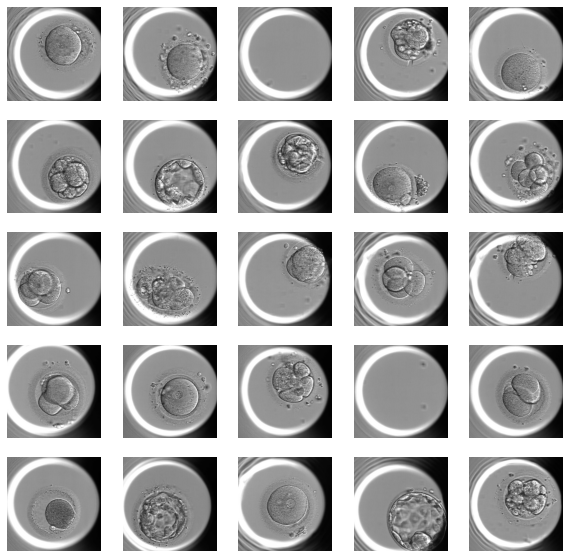

In [5]:
image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)

In [6]:
###### TF Version

In [9]:
with tf.device('/cpu:0'):
    list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))

# Check if the paths look correct
for f in list_ds.take(5):
  print(f.numpy())

b'/data/content/random/class_a/D2019_10_27_S00494_I3169_E11_5736.jpg'
b'/data/content/random/class_a/D2019_12_12_S00580_I3169_E3_6059.jpg'
b'/data/content/random/class_b/D2019_11_26_S00551_I3169_E4_6009.jpg'
b'/data/content/random/class_a/D2019_12_14_S00586_I3169_E13_7617.jpg'
b'/data/content/random/class_a/D2019_12_14_S00586_I3169_E5_2906.jpg'


In [10]:
def get_label():
  # convert the path to a list of path components
  rnd = np.random.uniform(0,1)
  if rnd > 0.5: out = 'A'
  if rnd <= 0.5: out = 'B'
  return out

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

def process_path(file_path):
  label = get_label() # Random label for this test.
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label



In [11]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
with tf.device('/cpu:0'):
    labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [13]:
for image, label in labeled_ds.take(2):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (800, 800, 3)
Label:  b'A'
Image shape:  (800, 800, 3)
Label:  b'A'


In [15]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
  ds = ds.repeat()

  ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

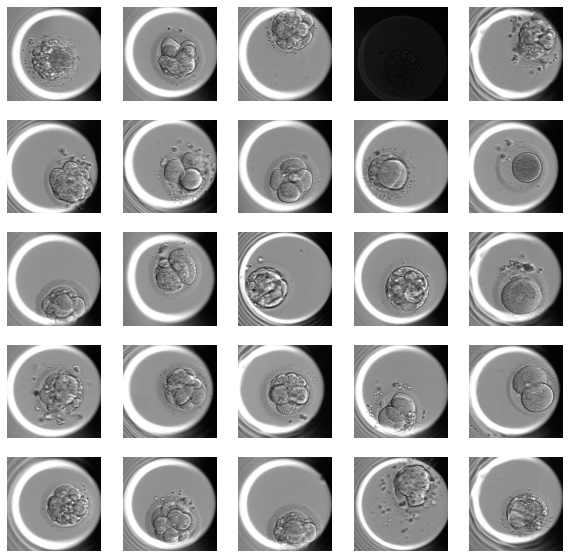

In [16]:
train_ds = prepare_for_training(labeled_ds)

image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())